# Rainfall prediction on Australia rainfall dataset

The Rain in Australia dataset contains about 10 years of daily weather observations from numerous Australian weather stations.
As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow.

more info on https://jovian.ai/aakashns/python-sklearn-logistic-regression

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the libraries

In [5]:
import pandas as pd

## Read the data

In [6]:
raindata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/machine-learning/rainfall-australia-prediction-logistic-regression/weatherAUS.csv')
raindata.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
raindata.shape

(145460, 23)

Let's check the data types and missing values in the various columns

In [8]:
raindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

While we should be able to fill in missing values for most columns, it might be a good idea to discard the rows where the value of RainTomorrow or RainToday is missing to make our analysis and modeling simpler (since one of them is the target variable, and the other is likely to be very closely related to the target variable).

In [9]:
raindata.dropna(subset=['RainToday','RainTomorrow'], inplace = True)

In [10]:
# raindata.info()

## Exploratory Data Analysis and Visualization

Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column. Let's explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries.

In [11]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [12]:
px.histogram(raindata, x='Location', color='RainToday', title='Location vs. Rainy Days')

In [13]:
px.histogram(raindata, x='Temp3pm', color='RainTomorrow', title = 'Temperature at 3PM vs. Rain Tomorrow')

In [14]:
px.histogram(raindata, x='RainToday', color='RainTomorrow', title = 'Rain Today vs. Rain Tomorrow')

In [15]:
px.scatter(raindata.sample(2000, random_state = 42), x='MinTemp', y='MaxTemp', color='RainToday')

In [16]:
px.scatter(raindata.sample(2000, random_state=42), x='Temp3pm', y='Humidity3pm', color='RainTomorrow')

Visualize all the other columns of the dataset and study their relationship with the `RainToday` and `RainTomorrow` columns.

## Training, Validation and Test Sets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique.

2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well.

3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.

https://i.imgur.com/j8eITrK.png

As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.

When rows in the dataset have no inherent order, it's common practice to pick random subsets of rows for creating test and validation sets. This can be done using the `train_test_split` utility from `scikit-learn`.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_val_df, test_df = train_test_split(raindata, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [19]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(84471, 23)
(28158, 23)
(28158, 23)


In [20]:
train_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
12319,2009-09-10,Moree,4.1,21.7,0.0,4.6,11.3,WNW,31.0,NNW,...,53.0,20.0,1019.3,1016.9,0.0,1.0,14.1,20.9,No,No
88560,2012-09-21,Cairns,18.9,30.0,0.0,8.0,11.1,NNE,30.0,S,...,54.0,38.0,1018.5,1013.7,1.0,1.0,25.7,29.2,No,No
42526,2017-06-05,Williamtown,7.3,18.5,0.2,NaN,NaN,NW,26.0,NW,...,94.0,60.0,1024.9,1021.6,6.0,NaN,10.6,18.0,No,No
139212,2008-10-10,Darwin,24.8,35.5,0.0,5.0,10.4,N,46.0,SE,...,80.0,52.0,1014.1,1010.4,3.0,2.0,28.5,32.9,No,No
25223,2012-01-01,Penrith,13.2,32.3,0.0,NaN,NaN,ENE,22.0,N,...,72.0,34.0,NaN,NaN,NaN,NaN,20.7,30.5,No,No


In [21]:
test_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
121459,2010-09-30,Perth,18.2,25.0,0.0,9.4,1.5,SE,33.0,SE,...,41.0,34.0,1011.1,1009.6,7.0,7.0,19.2,24.4,No,No
32051,2013-06-18,Sydney,8.0,19.2,0.0,1.6,8.0,S,43.0,W,...,76.0,52.0,1013.5,1012.2,1.0,2.0,9.6,16.1,No,Yes
107700,2015-02-06,Woomera,19.1,38.5,0.0,11.4,12.8,ENE,52.0,ESE,...,21.0,9.0,1017.5,1014.8,2.0,0.0,25.2,37.0,No,No
26526,2015-09-24,Penrith,8.4,17.5,0.0,NaN,NaN,S,54.0,SSW,...,47.0,44.0,NaN,NaN,NaN,NaN,13.5,15.4,No,No
109566,2011-09-22,Albany,9.5,14.5,2.4,3.0,5.3,NaN,NaN,SW,...,58.0,53.0,1021.6,1022.3,6.0,6.0,12.2,13.8,Yes,No


However, while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. 

Text(0.5, 1.0, 'No. of rows data per year')

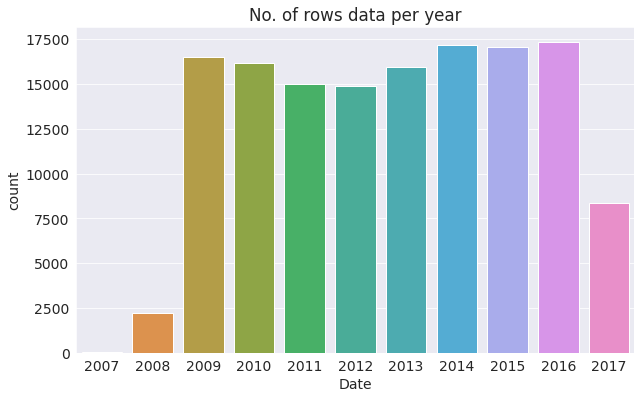

In [22]:
sns.countplot(x=pd.to_datetime(raindata.Date).dt.year)
plt.title('No. of rows data per year')

We'll pick the last two years 2016, 2017 for the test set, and 2015 for the validation set and before 2015, for training set

In [23]:
year = pd.to_datetime(raindata.Date).dt.year
train_df = raindata[year<2015]
val_df = raindata[year==2015]
test_df = raindata[year>2015]

In [24]:
print('train_df shape', train_df.shape)
print('val_df shape', val_df.shape)
print('test_df shape', test_df.shape)

train_df shape (97988, 23)
val_df shape (17089, 23)
test_df shape (25710, 23)


While not a perfect 60-20-20 split, we have ensured that the test validation and test sets both contain data for all 12 months of the year.

In [25]:
train_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [26]:
test_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
2498,2016-01-01,Albury,20.4,37.6,0.0,NaN,NaN,ENE,54.0,NaN,...,46.0,17.0,1013.4,1009.2,7.0,3.0,26.1,36.7,No,No
2499,2016-01-02,Albury,20.9,33.6,0.4,NaN,NaN,SSE,50.0,SSE,...,54.0,30.0,1011.1,1008.4,8.0,8.0,24.8,31.7,No,Yes
2500,2016-01-03,Albury,18.4,23.1,2.2,NaN,NaN,ENE,48.0,ESE,...,62.0,67.0,1014.0,1014.8,8.0,8.0,21.8,19.5,Yes,Yes
2501,2016-01-04,Albury,17.3,23.7,15.6,NaN,NaN,SSE,39.0,SE,...,74.0,65.0,1017.9,1016.5,8.0,8.0,19.2,21.6,Yes,Yes
2502,2016-01-05,Albury,15.5,22.9,6.8,NaN,NaN,ENE,31.0,SE,...,92.0,63.0,1016.3,1013.9,8.0,8.0,17.2,22.2,Yes,No
2503,2016-01-06,Albury,17.0,28.1,0.2,NaN,NaN,SE,39.0,SSE,...,76.0,52.0,1014.6,1012.6,8.0,8.0,20.3,25.7,No,No
2504,2016-01-07,Albury,16.4,28.0,0.0,NaN,NaN,SE,35.0,SE,...,46.0,31.0,1017.4,1015.7,NaN,2.0,20.9,26.6,No,No
2505,2016-01-08,Albury,14.3,31.7,0.0,NaN,NaN,NNW,24.0,SSE,...,63.0,24.0,1019.6,1017.2,NaN,8.0,19.4,28.7,No,No
2506,2016-01-09,Albury,16.7,35.0,0.0,NaN,NaN,WNW,28.0,E,...,52.0,24.0,1018.6,1015.5,NaN,3.0,24.2,33.1,No,No
2507,2016-01-10,Albury,17.8,37.0,0.0,NaN,NaN,SSW,41.0,ESE,...,54.0,17.0,1016.6,1012.6,NaN,NaN,26.2,36.2,No,No


## Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [27]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
print('input_cols: ', input_cols)
print('target_col: ', target_col)

input_cols:  ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']
target_col:  RainTomorrow


In [28]:
train_inputs = train_df[input_cols].copy()
train_target = train_df[target_col].copy()

In [29]:
val_inputs = val_df[input_cols].copy()
val_target = val_df[target_col].copy()

In [30]:
test_inputs = test_df[input_cols].copy()
test_target = test_df[target_col].copy()

In [31]:
train_inputs.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No


Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

In [32]:
import numpy as np

In [33]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
catagorical_cols = train_inputs.select_dtypes('object').columns.tolist()
print(numeric_cols)
print(catagorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [34]:
train_df[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.000000,97801.000000,97988.000000,61657.000000,57942.000000,91160.000000,97114.000000,96919.000000,96936.000000,96872.000000,88876.000000,88857.000000,63000.000000,61966.000000,97414.000000,97392.000000
mean,12.007831,23.022202,2.372935,5.289991,7.609004,40.215873,14.092263,18.764608,68.628745,51.469547,1017.513734,1015.132352,4.302952,4.410677,16.835126,21.540138
std,6.347175,6.984397,8.518819,3.952010,3.788813,13.697967,8.984203,8.872398,19.003097,20.756113,7.072510,6.997072,2.866634,2.693370,6.404586,6.831612
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000
25%,7.500000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.800000,1010.400000,1.000000,2.000000,12.200000,16.600000
50%,11.800000,22.400000,0.000000,4.600000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.500000,1015.100000,5.000000,5.000000,16.600000,20.900000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.300000,1019.900000,7.000000,7.000000,21.400000,26.200000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000


Do the ranges of the numeric columns seem reasonable? If not, we may have to do some data cleaning as well.

Let's also check the number of categories in each of the categorical columns.

In [35]:
train_df[catagorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

There are several techniques for imputation, but we'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.

In [36]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')

Before we perform imputation, let's check the no. of missing values in each numeric column.

In [37]:
train_df[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
Temp3pm            596
dtype: int64

The first step in imputation is to fit the imputer to the data i.e. compute the chosen statistic (e.g. mean) for each column in the dataset.

In [38]:
imputer.fit(raindata[numeric_cols])

SimpleImputer()

After calling `fit`, the computed statistic for each column is stored in the `statistics_` property of `imputer`.

In [39]:
list(imputer.statistics_)

[12.18482386562048,
 23.235120301822324,
 2.349974074310839,
 5.472515506887154,
 7.630539861047281,
 39.97051988882308,
 13.990496092519967,
 18.631140782316862,
 68.82683277087672,
 51.44928834695453,
 1017.6545771543717,
 1015.2579625879797,
 4.431160817585808,
 4.499250233195188,
 16.98706638787991,
 21.69318269001107]

The missing values in the training, test and validation sets can now be filled in using the `transform` method of `imputer`.

In [40]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

The missing values are now filled in with the mean of each column.

In [41]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## Scaling Numeric Features

Another good practice is to scale numeric features to a small range of values e.g. (0,1) or (−1,1). Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [42]:
raindata[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,140319.000000,140480.00000,140787.000000,81093.000000,73982.000000,131682.000000,139732.000000,138256.000000,139270.000000,137286.000000,127044.000000,127018.000000,88162.000000,84693.000000,140131.000000,138163.000000
mean,12.184824,23.23512,2.349974,5.472516,7.630540,39.970520,13.990496,18.631141,68.826833,51.449288,1017.654577,1015.257963,4.431161,4.499250,16.987066,21.693183
std,6.403879,7.11450,8.465173,4.189132,3.781729,13.578201,8.886210,8.798096,19.063650,20.807310,7.104867,7.035411,2.886594,2.719752,6.496012,6.937784
min,-8.500000,-4.80000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.90000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.60000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.30000,0.800000,7.400000,10.700000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.10000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to the $(0,1)$ range.

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
scaler = MinMaxScaler()

First, we `fit` the scaler to the data i.e. compute the range of values for each numeric column.

In [45]:
scaler.fit(raindata[numeric_cols])

MinMaxScaler()

We can now inspect the minimum and maximum values in each column.

In [46]:
print('Minimum: ', list(scaler.data_min_))

Minimum:  [-8.5, -4.8, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 980.5, 977.1, 0.0, 0.0, -7.2, -5.4]


In [47]:
print('Maximum: ', list(scaler.data_max_))

Maximum:  [33.9, 48.1, 371.0, 145.0, 14.5, 135.0, 130.0, 87.0, 100.0, 100.0, 1041.0, 1039.6, 9.0, 9.0, 40.2, 46.7]


We can now separately scale the training, validation and test sets using the `transform` method of `scaler`.

In [48]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

We can now verify that values in each column lie in the range $(0,1)$

In [49]:
train_inputs[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000,97988.000000
mean,0.483689,0.525947,0.006396,0.036949,0.525366,0.265107,0.108395,0.215668,0.686309,0.514693,0.612014,0.608705,0.483192,0.493693,0.507089,0.517103
std,0.149458,0.131904,0.022962,0.021628,0.200931,0.102420,0.068800,0.101424,0.189008,0.206376,0.111335,0.106611,0.255486,0.238028,0.134722,0.130726
min,0.000000,0.013233,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030400,0.000000,0.000000,0.027426,0.005758
25%,0.377358,0.429112,0.000000,0.026207,0.517241,0.193798,0.053846,0.149425,0.570000,0.370000,0.543802,0.540800,0.333333,0.333333,0.409283,0.422265
50%,0.478774,0.514178,0.000000,0.037741,0.526244,0.255814,0.100000,0.218391,0.690000,0.520000,0.614125,0.610527,0.492351,0.499917,0.502110,0.506718
75%,0.591981,0.618147,0.002156,0.038621,0.634483,0.310078,0.146154,0.275862,0.830000,0.650000,0.682645,0.675200,0.666667,0.666667,0.601266,0.604607
max,1.000000,1.000000,1.000000,0.568276,0.986207,1.000000,0.669231,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.988484


## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column. 

In [50]:
raindata[catagorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

We can perform one hot encoding using the `OneHotEncoder` class from `sklearn.preprocessing`.

In [51]:
from sklearn.preprocessing import OneHotEncoder

In [52]:
encoder = OneHotEncoder(sparse = False, handle_unknown='ignore')

First, we `fit` the encoder to the data i.e. identify the full list of categories across all categorical columns.

In [53]:
encoder.fit(raindata[catagorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [54]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'W', 'WNW', 'WSW', nan], dtype=object),
 ar

The encoder has created a list of categories for each of the categorical columns in the dataset. 

We can generate column names for each individual category using `get_feature_names`.

In [55]:
encoded_cols = list(encoder.get_feature_names_out(catagorical_cols))
print(encoded_cols);

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

All of the above columns will be added to `train_inputs`, `val_inputs` and `test_inputs`.

To perform the encoding, we use the `transform` method of `encoder`.

In [56]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[catagorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[catagorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[catagorical_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented 

We can verify that these new columns have been added to our training, test and validation sets.

In [57]:
pd.set_option('display.max_columns', None)

In [58]:
test_inputs

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_nan,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_nan,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes
2498,Albury,0.681604,0.801512,0.000000,0.037741,0.526244,ENE,0.372093,NaN,ESE,0.000000,0.080460,0.46,0.17,0.543802,0.5136,0.777778,0.333333,0.702532,0.808061,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037741,0.526244,SSE,0.341085,SSE,SE,0.069231,0.195402,0.54,0.30,0.505785,0.5008,0.888889,0.888889,0.675105,0.712092,No,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037741,0.526244,ENE,0.325581,ESE,ENE,0.084615,0.448276,0.62,0.67,0.553719,0.6032,0.888889,0.888889,0.611814,0.477927,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2501,Albury,0.608491,0.538752,0.042049,0.037741,0.526244,SSE,0.255814,SE,SSE,0.069231,0.195402,0.74,0.65,0.618182,0.6304,0.888889,0.888889,0.556962,0.518234,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Training a Logistic Regression Model

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results


Here's a visual summary of how a logistic regression model is structured ([source](http://datahacker.rs/005-pytorch-logistic-regression-in-pytorch/)):


<img src="https://i.imgur.com/YMaMo5D.png" width="480">

The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">

To train a logistic regression model, we can use the `LogisticRegression` class from Scikit-learn.

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
# ?LogisticRegression

In [61]:
model = LogisticRegression(solver='liblinear')

We can train the model using `model.fit`.

In [62]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_target)

LogisticRegression(solver='liblinear')

`model.fit` uses the following workflow for training the model ([source](https://www.deepnetts.com/blog/from-basic-machine-learning-to-deep-learning-in-5-minutes.html)):

1. We initialize a model with random parameters (weights & biases).
2. We pass some inputs into the model to obtain predictions.
3. We compare the model's predictions with the actual targets using the loss function.  
4. We use an optimization technique (like least squares, gradient descent etc.) to reduce the loss by adjusting the weights & biases of the model
5. We repeat steps 1 to 4 till the predictions from the model are good enough.


<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">

For a mathematical discussion of logistic regression, sigmoid activation and cross entropy, check out [this YouTube playlist](https://www.youtube.com/watch?v=-la3q9d7AKQ&list=PLNeKWBMsAzboR8vvhnlanxCNr2V7ITuxy&index=1). Logistic regression can also be applied to multi-class classification problems, with a few modifications.

Let's check the weights and biases of the trained model.

In [63]:
print(numeric_cols + encoded_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_

In [64]:
print(model.coef_.tolist())

[[0.8986297930345342, -2.8799204060649943, 3.1627757399992764, 0.8542333261963998, -1.671394164561986, 6.764390158247094, -0.9423158858733789, -1.4284258683428768, 0.3228997608393862, 5.995318372268631, 5.463846784453185, -9.17679795785107, -0.16230333435253397, 1.2876575040619256, 0.4747186064170006, 2.0214328984948513, 0.6016519028215679, -0.552477104469191, 0.47814423119684174, 0.0076658073824705615, 0.34681523049757107, -0.35227929992271934, 0.17971215004683533, 0.44048763345826203, -0.01398015208073661, 0.028943135225948075, 0.2581472778649235, -0.021207662838966575, -0.042792369348315706, -0.48314018877133696, -0.13756446769655933, -0.5760632042270655, -0.7875166742656966, -0.255401526390966, -0.32888762445550657, -0.5690081830628351, 0.08182990879409187, 0.01338244162954458, 0.06412637314153144, -0.9020547728556427, -0.44432692411493857, 0.008520520479860539, -0.4606123201969221, -0.46551901921036964, -0.06950134886943393, 0.1911583743352608, 0.45047746322189247, 0.6081203012953

In [65]:
print(model.intercept_)

[-2.44955509]


Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

## Making Predictions and Evaluating the Model

We can now use the trained model to make predictions on the training, test 

In [66]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [67]:
train_preds = model.predict(X_train)

In [68]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [69]:
train_target

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

We can output a probabilistic prediction using `predict_proba`.

In [70]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.94401112, 0.05598888],
       [0.94074168, 0.05925832],
       [0.96093614, 0.03906386],
       ...,
       [0.98749119, 0.01250881],
       [0.98334685, 0.01665315],
       [0.87453486, 0.12546514]])

The numbers above indicate the probabilities for the target classes "No" and "Yes".

In [71]:
model.classes_

array(['No', 'Yes'], dtype=object)

We can test the accuracy of the model's predictions by computing the percentage of matching values in `train_preds` and `train_targets`.

This can be done using the `accuracy_score` function from `sklearn.metrics`.

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
accuracy_score(train_target, train_preds)

0.8519206433440829

The model achieves an accuracy of 85.1% on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix.

<img src="https://i.imgur.com/UM28BCN.png" width="480">

In [74]:
from sklearn.metrics import confusion_matrix

In [75]:
confusion_matrix(train_target, train_preds, normalize='true')

array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

In [76]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 85.19%


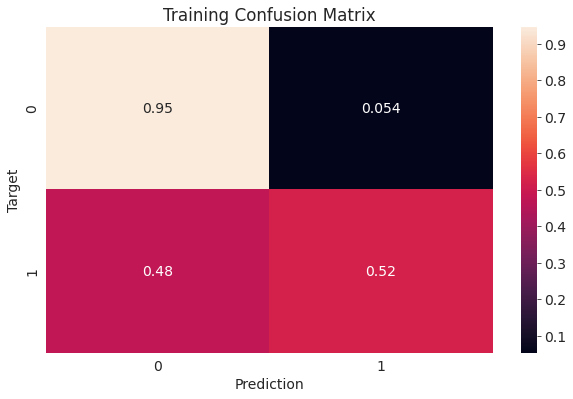

In [77]:
train_preds = predict_and_plot(X_train, train_target, 'Training')

Let's compute the model's accuracy on the validation and test sets too.

Accuracy: 85.40%


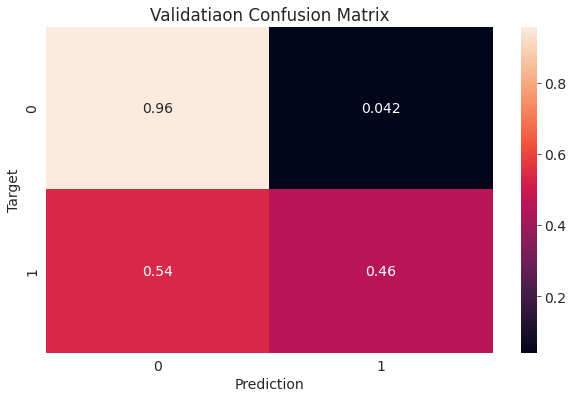

In [78]:
val_preds = predict_and_plot(X_val, val_target, 'Validatiaon')

Accuracy: 84.20%


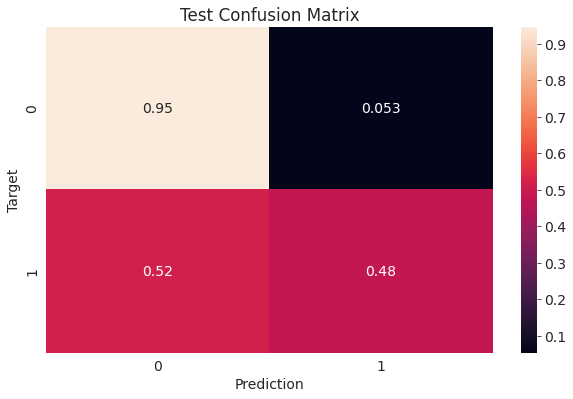

In [79]:
test_preds = predict_and_plot(X_test, test_target, 'Test')